🔢 Importación y carga inicial

Distribución de clases (0 = no fraude, 1 = fraude):
is_fraud
0    1842743
1       9651
Name: count, dtype: int64

Porcentaje de cada clase:
is_fraud
0    99.48
1     0.52
Name: proportion, dtype: float64


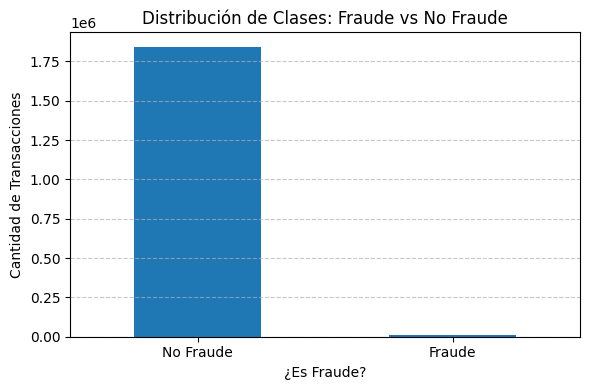

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV
df = pd.read_csv('data.csv')  # Cambia por el nombre de tu archivo real

df['is_fraud'] = df['is_fraud'].astype(int)

# Conteo de clases
class_counts = df['is_fraud'].value_counts()
print("Distribución de clases (0 = no fraude, 1 = fraude):")
print(class_counts)

# Porcentaje
class_percent = df['is_fraud'].value_counts(normalize=True) * 100
print("\nPorcentaje de cada clase:")
print(class_percent.round(2))

# Visualización
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.title("Distribución de Clases: Fraude vs No Fraude")
plt.xlabel("¿Es Fraude?")
plt.ylabel("Cantidad de Transacciones")
plt.xticks(ticks=[0,1], labels=["No Fraude", "Fraude"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


📊 Variables agregadas por usuario

In [ ]:
# Transacciones por usuario
df['transacciones_por_usuario'] = df.groupby('cc_num')['cc_num'].transform('count')

# Monto total gastado por usuario
df['monto_total_usuario'] = df.groupby('cc_num')['amt'].transform('sum')

# Promedio de gasto por usuario
df['monto_promedio_usuario'] = df['monto_total_usuario'] / df['transacciones_por_usuario']

# quincena
df['quincena'] = df['trans_day'].apply(lambda d: 'quincena_1' if d <= 15 else 'quincena_2')


#compras lejanas
df["is_international_guess"] = df["dist_between_client_and_merch"] > 1000


# Compra de noche #horas de la noche
df['es_noche'] = df['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# Distancia sospechosa
df['distancia_muy_lejana'] = (df['dist_between_client_and_merch'] > 100).astype(int)




In [ ]:
#distancia entre estados no distancia quemada de cliente si no un promedio o un radio 

In [3]:
categorias_riesgosas = ['misc_net', 'shopping_net', 'shopping_pos']

df['comercio_riesgoso'] = df['category'].isin(categorias_riesgosas).astype(int)


riesgo_por_categoria = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
print(riesgo_por_categoria)


category
shopping_net      0.015927
misc_net          0.013039
grocery_pos       0.012645
shopping_pos      0.006344
gas_transport     0.004106
misc_pos          0.002819
grocery_net       0.002697
travel            0.002692
personal_care     0.002229
entertainment     0.002177
kids_pets         0.001880
food_dining       0.001568
home              0.001510
health_fitness    0.001510
Name: is_fraud, dtype: float64


💰 Alto riesgo

In [4]:
umbral_alto = df['amt'].quantile(0.90)  # o cualquier otro criterio

df['transaccion_alto_riesgo'] = ((df['amt'] > umbral_alto) & (df['comercio_riesgoso'] == 1)).astype(int)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Excluir columnas no útiles
exclude_cols = ['cc_num', 'first', 'last', 'street', 'job', 'dob', 'trans_num', 'merchant']
X = df.drop(columns=exclude_cols, errors='ignore')
y = df['is_fraud']

#Convertir categóricas a dummies
X = pd.get_dummies(X)

#Convertir booleanos a enteros
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

#Separar train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6756, number of negative: 1289919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5674
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 938
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005210 -> initscore=-5.251904
[LightGBM] [Info] Start training from score -5.251904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

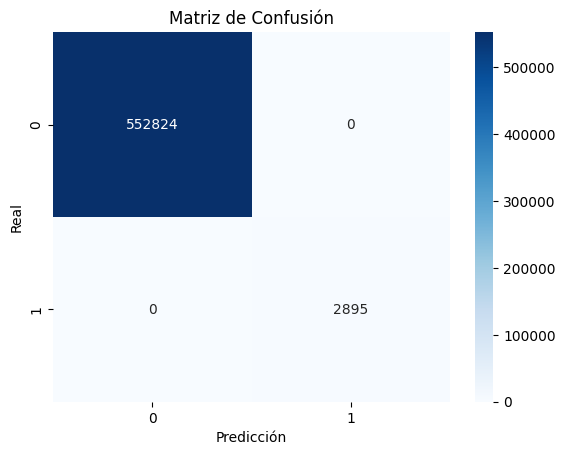

In [ ]:
#Entrenar modelo base con LightGBM
modelo = lgb.LGBMClassifier(random_state=42)
modelo.fit(X_train, y_train)

#Predicciones
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]

# Evaluar desempeño
auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
print(f"AUC-ROC: {auc:.4f}")
print(f"F1-score: {f1:.4f}")

# Matriz de confusión y reporte
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


🔍  Limpieza para modelo base

In [ ]:
#verificar que es la compra internacional para sacar el modelo (entre estados y asi)


columnas_originales = [
    'amt', 'category', 'merchant', 'lat', 'long',
    'merch_lat', 'merch_long', 'hour', 'trans_day', 'trans_month'
]

df_simple = df[columnas_originales + ['is_fraud']].copy()

# One-hot encoding
df_simple = pd.get_dummies(df_simple)

# Reemplazar caracteres especiales en los nombres de las columnas
df_simple.columns = df_simple.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Separar features y etiquetas
X = df_simple.drop(columns=['is_fraud'])
y = df_simple['is_fraud']

# División en entrenamiento y test
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Entrenamiento del modelo base
import lightgbm as lgb

modelo = lgb.LGBMClassifier(random_state=42)
modelo.fit(X_train, y_train)

# Predicciones
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]

# Evaluación
print("AUC:", roc_auc_score(y_test, y_prob))
print("F1-score:", f1_score(y_test, y_pred))


[LightGBM] [Info] Number of positive: 6756, number of negative: 1289919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2728
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 715
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005210 -> initscore=-5.251904
[LightGBM] [Info] Start training from score -5.251904
AUC: 0.896253206678514
F1-score: 0.6458141674333027


In [20]:
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"Fraudes detectados (True Positives): {tp}")
print(f"Falsos positivos: {fp}")
print(f"Verdaderos negativos: {tn}")
print(f"Fraudes no detectados (False Negatives): {fn}")


Fraudes detectados (True Positives): 1755
Falsos positivos: 785
Verdaderos negativos: 552039
Fraudes no detectados (False Negatives): 1140
